# EECE5644 Final Project
## Image Classification of Mars Curiosity Rover 
### Ethan Holand and Jarrod Homer
***

In [32]:
import matplotlib.pyplot as plt # For general plotting

import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as transforms

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
random_seed = 7
np.random.seed(random_seed)
torch.manual_seed(random_seed)

Dataset has 3746 samples
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]), array([  24,    5,   12,   38,   15,   29,    3,    6, 1874,  179,  132,
         11,   26,   29,   81,   68,   14,   58,    6,   10,   46,  133,
        142,   55], dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]), array([  6,   1,   3,   9,   4,   7,   1,   2, 469,  45,  33,   3,   6,
         7,  20,  17,   4,  15,   2,   2,  11,  33,  36,  14], dtype=int64))
ground turret turret ground ground horizon ground ground


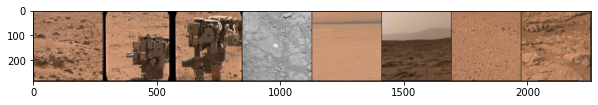

In [33]:
# Define how transform the data for processing in batches
transform = transforms.Compose([
        transforms.Resize([280,280]), # Resizing the image
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.0,0.0,0.0), std=(1.0,1.0,1.0))
    ])

# Specify the batch size for SGD
batch_size = 64
# Use the ImageFolder class, which is a generic dataloder useful when images stored in labelled directories
# Apply transform to images specified above, importantly converting "ToTensor"
dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\Project\rearrangedFiles\train', transform=transform)
# Specify classes for convenience in printing
classes = ('apxs', 'apxs cal target', 'chemcam cal target', 'chemin inlet open', 'drill', 'drill holes', 'drt front', 'drt side', 'ground', 'horizon', 'inlet', 'mahli', 'mahli cal target', 'mastcam', 'mastcam cal target', 'observation tray', 'portion box', 'portion tube', 'portion tube opening', 'rems uv sensor', 'rover rear deck', 'scoop', 'turret', 'wheel')
print("Dataset has {} samples".format(len(dataset)))

# List of targets/labels for entire dataset
targets = dataset.targets
# Use sklearn function to split the data into training-test sets (80-20 split)
# Stratified ensures that same percentage of samples of each target class form a complete set
train_idx, test_idx= train_test_split(
    np.arange(len(targets)), test_size=0.2, random_state=random_seed, shuffle=True, stratify=targets)

# Printing the unique class labels in each split set and the number of occurrences per class
print(np.unique(np.array(targets)[train_idx], return_counts=True))
print(np.unique(np.array(targets)[test_idx], return_counts=True))

# Create training and test subsets based on split indices
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

# Define iterable for our newly created dataset and shuffle samples 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

### Plotting stuff ###
fig = plt.figure(figsize=(10,15))
# Utility function to show an image
def imshow(img):
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))

# Get some random training dataset images
dataiter = iter(train_dataloader)
# Extract a batch
images, labels = dataiter.next()
# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [34]:
# Note that PyTorch uses NCHW (samples, channels, height, width) image format convention
class ConvNet(nn.Module):
    def __init__(self, in_channels, num_filters, out_classes, kernel_size=3):
        super().__init__()
        # Conv2D layer with 'same' padding so image retains shape
        self.conv1 = nn.Conv2d(in_channels, num_filters, kernel_size, padding='same')
        self.drop = nn.Dropout(p=0.2)
        #self.dropout = 
        # MaxPooling layer with 2x2 kernel size and stride 2
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size, padding='same')
        self.fc1 = nn.Linear(num_filters*2*70*70, num_filters)
        self.fc2 = nn.Linear(num_filters, out_classes)

    def forward(self, x):
        # Non-linear ReLU activations between convolutional layers
        # Conv->ReLU->Pooling
        # 280x280 image -> 140x140 after pooling
        x = self.pool(self.drop(F.relu(self.conv1(x))))
        # 140x140 feature map -> 70x70 after pooling
        x = self.pool(self.drop(F.relu(self.conv2(x))))
        # Flatten all dimensions except batch (start_dim=1)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

input_channels = images.shape[1]
model = ConvNet(input_channels, num_filters=16, out_classes=len(classes))
summary(model, input_size=(input_channels, 280, 280))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            448
├─Dropout: 1-2                           --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            4,640
├─Linear: 1-5                            2,508,816
├─Linear: 1-6                            408
Total params: 2,514,312
Trainable params: 2,514,312
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            448
├─Dropout: 1-2                           --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            4,640
├─Linear: 1-5                            2,508,816
├─Linear: 1-6                            408
Total params: 2,514,312
Trainable params: 2,514,312
Non-trainable params: 0

In [35]:
def model_train_loader(model, dataloader, criterion, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        predictions = model(X)
        loss = criterion(predictions, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Report loss every 10 batches
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
            
def model_test_loader(model, dataloader, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Tracking test loss (cross-entropy) and correct classification rate (accuracy)
    test_loss, correct = 0, 0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            predictions = model(X)
            test_loss += criterion(predictions, y)
            correct += (predictions.argmax(1) == y).type(torch.float).sum()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
# The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to output
criterion = nn.CrossEntropyLoss()
num_epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_train_loader(model, train_dataloader, criterion, optimizer)
    model_test_loader(model, test_dataloader, criterion)

Epoch 1
-------------------------------
loss: 3.337905  [    0/ 2996]
loss: 1.666041  [  640/ 2996]
loss: 1.525396  [ 1280/ 2996]
loss: 1.338090  [ 1920/ 2996]
loss: 1.561927  [ 2560/ 2996]
Test Error: 
 Accuracy: 62.5%, Avg loss: 1.665067 

Epoch 2
-------------------------------
loss: 1.313765  [    0/ 2996]
loss: 1.554286  [  640/ 2996]
loss: 1.262057  [ 1280/ 2996]
loss: 1.619404  [ 1920/ 2996]
loss: 1.439948  [ 2560/ 2996]
Test Error: 
 Accuracy: 62.8%, Avg loss: 1.371327 

Epoch 3
-------------------------------
loss: 1.618893  [    0/ 2996]
loss: 1.279086  [  640/ 2996]
loss: 1.149457  [ 1280/ 2996]
loss: 1.167666  [ 1920/ 2996]
loss: 0.719214  [ 2560/ 2996]
Test Error: 
 Accuracy: 68.5%, Avg loss: 1.177149 

Epoch 4
-------------------------------
loss: 1.246243  [    0/ 2996]
loss: 1.246122  [  640/ 2996]
loss: 1.124498  [ 1280/ 2996]
loss: 1.360955  [ 1920/ 2996]
loss: 1.030712  [ 2560/ 2996]
Test Error: 
 Accuracy: 69.7%, Avg loss: 1.147350 

Epoch 5
------------------------

GroundTruth:  ground ground ground ground inlet ground ground ground ground mastcam ground ground ground ground ground ground ground drt side ground ground ground ground ground ground horizon ground ground ground ground ground ground ground horizon ground ground ground mahli cal target ground ground rover rear deck scoop ground scoop ground drill scoop chemin inlet open ground ground ground ground ground ground rover rear deck turret rover rear deck ground mahli ground ground ground ground ground ground
Predicted:  ground ground ground ground inlet ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground ground inlet ground inlet horizon turret ground inlet ground inlet ground inlet ground ground ground ground ground ground ground turret ground ground inlet ground ground ground ground ground ground


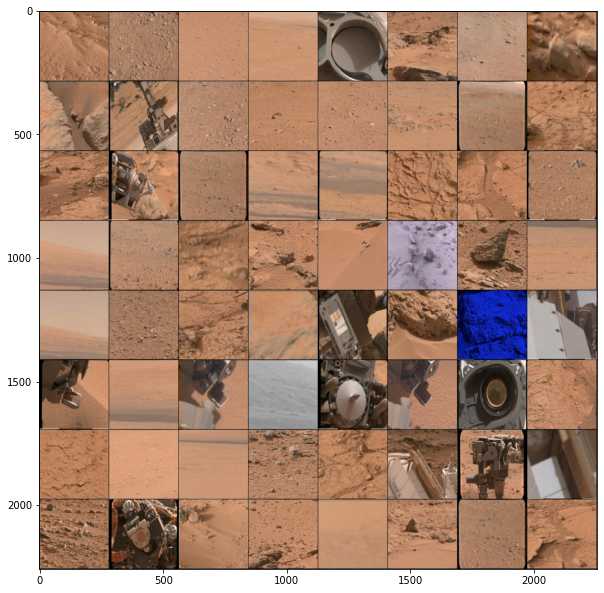

In [37]:
### Plotting stuff ###
fig = plt.figure(figsize=(10,15))

# Get some random test dataset images
dataiter = iter(test_dataloader)
# Extract a batch
images, labels = dataiter.next()
# Show images
imshow(torchvision.utils.make_grid(images[:64]))
# Print labels
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

outputs = model(images)
# Argmax take the most probable class
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(64)))